In [48]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import random
import pickle
import torch
from torch.autograd import Variable, Function

In [2]:

dataset = 'amazon'
# load group mappings

member2group = defaultdict(list)
group2member = defaultdict(list)
edges = defaultdict(int)

# create member edge
with open('{}/com-{}.ungraph.txt'.format(dataset, dataset), 'r') as f:
    for line in tqdm(f.readlines()):
        edge = [ str(int(m)) for m in line.split('\t')]
        edge = '_'.join(edge)
        edges[edge] = 1

# load directed graph
with open('{}/com-{}.all.cmty.txt'.format(dataset, dataset), 'r') as f: 
    for line in tqdm(f.readlines()):
        members = line.split('\t')
        members = [ int(m) for m in members]
        group_id = len(group2member)
        group2member[group_id] = members
        for m in members:
            member2group[m].append(group_id)


100%|██████████| 75149/75149 [00:00<00:00, 79232.54it/s]


In [3]:
G = nx.Graph()
for edge in edges:
    src, dst = edge.split('_')
    src, dst = int(src), int(dst)
    
    if not G.has_node(src):
        G.add_node(src, group=member2group[src])

    if not G.has_node(dst):
        G.add_node(dst, group=member2group[dst])
    
    if G.has_node(src) and G.has_node(dst):
        G.add_edge(src, dst)


In [78]:
hit_rate = []
idx = 0
for group_id, members in tqdm(group2member.items(), dynamic_ncols=True):
#     print(members)
    random.shuffle(members)
    ratio = int(len(members)*0.8)
    exist_nodes = members[:ratio]
    sub_graph_nodes = []
    for node in exist_nodes:
        n_nodes = nx.single_source_shortest_path_length(G, node, cutoff=2)
        sub_graph_nodes += [n for n in n_nodes]
    sub_graph_nodes = set(sub_graph_nodes)
    sub_G = nx.Graph()
    in_group_cnt = 0
    for nodes in sub_graph_nodes:
        in_group = 1 if nodes in members else 0
        predict = 0
        if nodes in exist_nodes:
            predict = 0
        elif nodes in members and nodes not in exist_nodes:
            predict = 1
        in_group_cnt += in_group
        sub_G.add_node(nodes, in_group=in_group, predict=predict)
    hit_rate.append(in_group_cnt/len(members))
#     print('total : ',in_group_cnt)
#     print(len(sub_G.nodes))
    for nodes in sub_graph_nodes:
        for n in G.neighbors(nodes):
            if sub_G.has_node(nodes) and sub_G.has_node(n):
                sub_G.add_edge(nodes, int(n))
    idx += 1
    if idx > 100:
        break
#     print(len(sub_G.nodes))
#     print(len(sub_G))







  0%|          | 0/75149 [00:00<?, ?it/s]




  0%|          | 92/75149 [00:00<01:26, 872.23it/s]


In [54]:
filename = 'graphv/amazon-64-DeepWalk.pkl'
with open(filename, 'rb') as f:
    embeddings = pickle.load(f)

In [80]:
from torch_geometric.data import InMemoryDataset, Data
matrix = embeddings['embedding']
name2id = embeddings['name2id']
matrix_dim = len(matrix[0])
graph_idx = {}

# does the order of index matter?
# seems to me it's relative to one and another?
for n in G.nodes:
    graph_idx[n] = len(graph_idx)

nodes = []
edges = []
labels = []

for n in tqdm(sub_G.nodes):
    node_latent = torch.rand(matrix_dim, requires_grad=True)
    if str(n) in name2id:
        node_latent = Variable(torch.from_numpy(matrix[name2id[str(n)]]))
    edge_index = np.array(list( G.edges(n)))
    new_edges = []
    for idx in range(len(edge_index)):
        src, dst = edge_index[idx]
        edge_index[idx] = [graph_idx[src], graph_idx[dst]  ]
        new_edges.append([graph_idx[dst], graph_idx[src]  ])
    edges.append(np.array(new_edges))
    edges.append(edge_index)
    nodes.append(node_latent.unsqueeze(0))
    label = torch.zeros((1, 3))
    labels.append(sub_G.nodes[n]['predict'])

x = torch.stack(nodes)
edges = torch.from_numpy(np.transpose(np.concatenate(edges)))
y = torch.from_numpy(np.array(labels))
data = Data(x=x, edge_index=edges, y=y)






100%|██████████| 67/67 [00:00<00:00, 18168.90it/s]


In [81]:
data

Data(edge_index=[2, 1004], x=[67, 1, 64], y=[67])

In [42]:
for node_id in sub_G.nodes:
    nodes = sub_G.nodes[node_id]
    print(nodes)
    if 'predict' in nodes:
        print(nodes['predict'])
    else:
        print(nodes,' not found')

{'in_group': 0, 'predict': -1}
-1
{'in_group': 1, 'predict': 1}
1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 1, 'predict': 0}
0
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 1, 'predict': 0}
0
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'predict': -1}
-1
{'in_group': 0, 'pre

In [22]:
sub_G.nodes[257630].in_group

{'in_group': 1}

In [32]:
stats = defaultdict(int)
group_size = defaultdict(int)
group_num = 0
for group_id, members in tqdm(group2member.items()):
    for idx, src in enumerate(members):
        for jdx, dst in enumerate(members[idx+1:]):
            distance = nx.shortest_path_length(G, source=src, target=dst)
            stats[distance] += 1
    group_size[len(members)] += 1
    group_num += 1
    if group_num > 1000:
        break


  1%|▏         | 972/75149 [10:48<210:13:32, 10.20s/it]

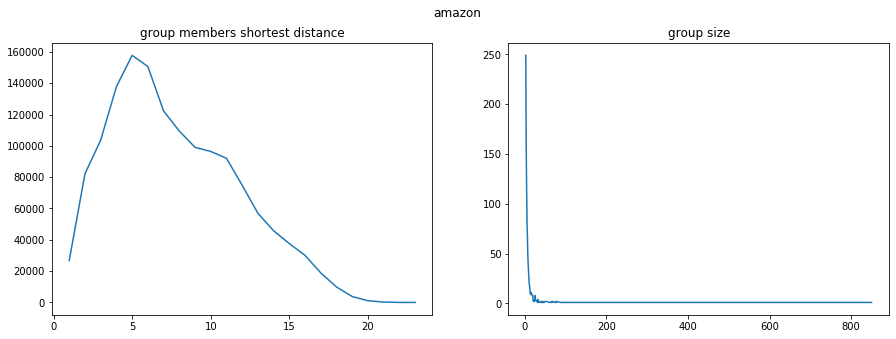

In [41]:
fig2, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,5)) # two axes on figure
fig2.suptitle(dataset)
data = {
    'x': [ key for key, _ in stats.items() ],
    'y': [ size for _, size in stats.items() ],
}
ax1.set_title('group members shortest distance')
sns.lineplot(x='x', y='y', data=data, ax=ax1)
data = {
    'x': [ key for key, _ in group_size.items() ],
    'y': [ size for _, size in group_size.items() ],
}
ax2.set_title('group size')
sns.lineplot(x='x', y='y', data=data, ax=ax2)
fig2.savefig('{}.png'.format(dataset))